<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Calwebb_Detector1, Jump step

<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

Tested on MIRI Ground Test data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Run JWST Pipelines](#pipeline_ID) <br> [Imports](#imports_ID) <br> [Read in Input files](#runpipeline_ID) <br> [Insert Cosmic Ray jumps to be tested and run pipeline](#runscript_ID)  <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>
# Introduction


This test is designed to test the jump step in the calwebb_detector1 pipeline. This is the step that checks for outliers in each individual ramp and flags jumps (cosmic rays or other anomalies). For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/index.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/jump

The data for this test was taken as part of ground testing. The file was originally named MIRM107-E-6021041029_1_493_SE_2016-01-21T04h22m18.fits and is an Imaging file from test IMG-RAD-17 with a point source centered at pixel (702,452) with a slope value of around 300 DN/s. It consists of 5 integrations of 20 frames each. The file was processed into a format compatible with the pipeline using a script called create_data and renamed to jw04192001001_01101_00001_MIRIMAGE_uncal.fits.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Ramp+Jump+Detection


### Defining Terms
Definition of terms or acronymns.

JWST: James Webb Space Telescope

MIRI: Mid-Infrared Instrument



### Description of test

This test is performed by taking the uncal file which was the output of the script create_data, adding known cosmic ray jumps of varying strength at specified pixels and running it through the calibration pipeline to see if the pixels are flagged as jumps. The pipeline flags the four neighboring pixels of a jump detection if the jump is high enough (10 sigma?). It then checks to see if the single pixel cosmic ray was detected, and whether the neighboring pixels were also flagged.


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
## Run JWST Pipelines

The file was run through the calwebb_detector1 pipeline, outputting the resulting file for the jump step specifically. When running the calwebb_detector1 pipeline, increase the threshold for a detection in the jump step from 4 sigma to 6 sigma to avoid a current issue where the jump detection step flags too many pixels as jumps. We should also use a different saturation file to make sure saturation is handled correctly (while waiting for an update to the reference file in CRDS).


[Top of Page](#title_ID)

<a id="imports_ID"></a>
# Imports
The following packages will need to be imported for the scripts to work.


* jwst.datamodels for opening files as a JWST Datamodel
* jwst.pipeline to run the pipeline step/module
* numpy for calculations
* os for path information  
* get_bigdata to retrieve data from artifactory
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output


[Top of Page](#title_ID)

In [1]:
import numpy as np
import os
from jwst.datamodels import RampModel, SaturationModel, dqflags
from jwst.pipeline import Detector1Pipeline
from jwst.jump import JumpStep
from ci_watson.artifactory_helpers import get_bigdata
import inspect
from IPython.display import Markdown
import matplotlib.pyplot as plt

In [2]:
# Needed to read in old file with DATAMODL=MIRIRampModel instead of RampModel
os.environ['SKIP_FITS_UPDATE'] = 'false'

In [3]:
import jwst
jwst.__version__

'0.17.1'

In [4]:
# Get raw python docstring and show definition for Pipeline
raw = inspect.getdoc(JumpStep)

# To convert to markdown, you need convert line breaks from \n to <br />
markdown_text = "<br />".join(raw.split("\n"))

# Here you can format markdown as an output using the Markdown method.
Markdown("""
# Jump Step
---
{}
""".format(markdown_text))


# Jump Step
---
JumpStep: Performs CR/jump detection on each ramp integration within an<br />exposure. The 2-point difference method is applied.


<a id="runpipeline_ID"></a>
# Read in input files

Use artifactory to store both input and specified saturation file, then read them out with bigdata to run them through the pipeline.

[Top of Page](#title_ID)

In [5]:
# read in Input files

file = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',
                     'jump_miri_test', 
                     'jw04192001001_01101_00001_MIRIMAGE_uncal.fits')

satfile = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',                     
                     'jump_miri_test', 
                     'miri_sat_55k.fits')

filename = 'jw04192001001_01101_00001_MIRIMAGE_uncal.fits'

# Temporary fix until the file can be loaded into artifactory

#hduref = fits.open('jw04192001001_01101_00001_MIRIMAGE_uncal.fits')  # read in each file
#hd = hduref[0].header
#hd['DATAMODL'] = 'RampModel'
#hduref.writeto('jw04192001001_01101_00001_MIRIMAGE_uncal.fits', overwrite=True)

satfilename = 'miri_sat_55k.fits'    
   
im = RampModel('jw04192001001_01101_00001_MIRIMAGE_uncal.fits')
sat = SaturationModel('miri_sat_55k.fits')


<a id="runscript_ID"></a>
# Insert Cosmic Ray jumps to be tested and run pipeline

Put in the locations and strengths of several cosmic rays, then run the pipeline on the data.



[Top of Page](#title_ID)

#### Put in cosmic ray jumps

In [6]:
# set variables
rej_thresh = 6.0  # rejection threshold for jump step

# Choose selected pixels to put cr hits of varying fluxes in
xpos = [460, 480, 500, 520, 540, 560, 580]
ypos = [150, 150, 150, 150, 150, 150, 150]
crmags = [10, 25, 50, 100, 200, 500, 1000]

frame = 5  # frame to add cr
integration = 0  # integration to add crs

#### Set up parameters and run pipeline



In [7]:
imagefile = str(im.meta.filename)
print(imagefile)

# loop through arrays of x, y and crmags to populate array with values
for x, y, crmag in zip(xpos, ypos, crmags):
    # add cr to ramps from point of 'frame' in ramp
    im.data[integration, frame:, y, x] = im.data[integration, frame:, y, x] + crmag


# run cube with cr hits through jump
# set up pipeline parameters for input
pipe1 = Detector1Pipeline()
pipe1.jump.rejection_threshold = rej_thresh
pipe1.saturation.override_saturation = satfile
 
# set up output file name
base, remainder = imagefile.split('_uncal')
print(base)
outname = base

pipe1.jump.save_results = True
pipe1.jump.output_file = outname + '.fits'
pipe1.ramp_fit.output_file = outname + '.fits'
pipe1.output_file = outname + '.fits'


# Run pipeline on each file
pipe1.run(im)

print('Pipeline run finished')

2021-01-04 16:00:48,614 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-01-04 16:00:48,615 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-01-04 16:00:48,616 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-01-04 16:00:48,617 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-01-04 16:00:48,618 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-01-04 16:00:48,619 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-01-04 16:00:48,620 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-01-04 16:00:48,621 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.


2021-01-04 16:00:48,623 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-01-04 16:00:48,624 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-01-04 16:00:48,625 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-01-04 16:00:48,626 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-01-04 16:00:48,627 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-01-04 16:00:48,628 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-01-04 16:00:48,629 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-01-04 16:00:48,631 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-01-04 16:00:48,742 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:00:48,751 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/jwst_validation_notebooks/jump/jwst_jump_miri_test/jw04192001001_01101_00001_MIRIMAGE.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_result

2021-01-04 16:00:48,760 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw04192001001_01101_00001_MIRIMAGE_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'rscd', 'superbias', 'trapdensity', 'trappars']


jw04192001001_01101_00001_MIRIMAGE_uncal.fits
jw04192001001_01101_00001_MIRIMAGE


2021-01-04 16:00:48,985 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits'.


2021-01-04 16:00:48,986 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.


2021-01-04 16:00:48,986 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits'.


2021-01-04 16:00:48,987 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.


2021-01-04 16:00:48,988 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits'.


2021-01-04 16:00:48,988 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-01-04 16:00:48,989 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits'.


2021-01-04 16:00:48,989 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-01-04 16:00:48,989 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.


2021-01-04 16:00:48,990 - stpipe.Detector1Pipeline - INFO - Override for SATURATION reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/jwst_validation_notebooks/jump/jwst_jump_miri_test/miri_sat_55k.fits'.


2021-01-04 16:00:48,990 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-01-04 16:00:48,990 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-01-04 16:00:48,991 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-01-04 16:00:48,991 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-01-04 16:00:49,120 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:00:49,121 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-01-04 16:00:49,129 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-01-04 16:00:49,130 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-01-04 16:00:49,131 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-01-04 16:00:49,258 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:00:49,259 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-01-04 16:00:49,271 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits


2021-01-04 16:00:50,440 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-01-04 16:00:50,578 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:00:50,580 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-01-04 16:00:50,588 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/jwst_validation_notebooks/jump/jwst_jump_miri_test/miri_sat_55k.fits


2021-01-04 16:00:52,161 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-01-04 16:00:52,307 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:00:52,308 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-01-04 16:00:52,320 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits


2021-01-04 16:00:55,784 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-01-04 16:00:55,952 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:00:55,954 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-01-04 16:00:56,708 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-01-04 16:00:56,834 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:00:56,835 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-01-04 16:00:57,581 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-01-04 16:00:57,722 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:00:57,723 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-01-04 16:00:57,734 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits


2021-01-04 16:00:59,424 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-01-04 16:00:59,552 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:00:59,554 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-01-04 16:00:59,565 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits


2021-01-04 16:01:00,241 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-01-04 16:01:00,390 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:01:00,391 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-01-04 16:01:00,402 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits


2021-01-04 16:01:02,322 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=5, ngroups=20, nframes=1, groupgap=0


2021-01-04 16:01:02,323 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-01-04 16:01:03,991 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-01-04 16:01:04,378 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:01:04,379 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-01-04 16:01:04,388 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-01-04 16:01:04,389 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-01-04 16:01:04,389 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-01-04 16:01:04,390 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-01-04 16:01:04,390 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-01-04 16:01:05,069 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2021-01-04 16:01:06,462 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2021-01-04 16:01:06,723 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-01-04 16:01:06,897 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_uncal.fits>,).


2021-01-04 16:01:06,899 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/jwst_validation_notebooks/jump/jwst_jump_miri_test/jw04192001001_01101_00001_MIRIMAGE.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 6.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-01-04 16:01:06,908 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 6 sigma


2021-01-04 16:01:06,911 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2021-01-04 16:01:06,928 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2021-01-04 16:01:06,967 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-01-04 16:01:08,197 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-01-04 16:01:11,049 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1


2021-01-04 16:01:12,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 4518 pixels with at least one CR


2021-01-04 16:01:12,739 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 2


2021-01-04 16:01:13,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 2233 pixels with at least one CR


2021-01-04 16:01:14,047 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 3


2021-01-04 16:01:15,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 2097 pixels with at least one CR


2021-01-04 16:01:15,376 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 4


2021-01-04 16:01:16,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 1880 pixels with at least one CR


2021-01-04 16:01:16,661 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 5


2021-01-04 16:01:18,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 1883 pixels with at least one CR


2021-01-04 16:01:19,183 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.9782 sec


2021-01-04 16:01:19,187 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 12.279186


2021-01-04 16:01:19,949 - stpipe.Detector1Pipeline.jump - INFO - Saved model in jw04192001001_01101_00001_MIRIMAGE_jump.fits


2021-01-04 16:01:19,950 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-01-04 16:01:20,154 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(5, 20, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_jump.fits>,).

2021-01-04 16:01:20,156 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/jwst_validation_notebooks/jump/jwst_jump_miri_test/jw04192001001_01101_00001_MIRIMAGE.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-01-04 16:01:20,170 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2021-01-04 16:01:20,181 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2021-01-04 16:01:20,192 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-01-04 16:01:20,193 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-01-04 16:01:20,421 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-01-04 16:01:20,423 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-01-04 16:03:49,015 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 20


2021-01-04 16:03:49,017 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 5


2021-01-04 16:03:49,155 - stpipe.Detector1Pipeline.ramp_fit - INFO - Saved model in jw04192001001_01101_00001_MIRIMAGE_0_ramp_fit.fits


2021-01-04 16:03:49,291 - stpipe.Detector1Pipeline.ramp_fit - INFO - Saved model in jw04192001001_01101_00001_MIRIMAGE_1_ramp_fit.fits


2021-01-04 16:03:49,292 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-01-04 16:03:49,485 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_0_ramp_fit.fits>,).


2021-01-04 16:03:49,487 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-01-04 16:03:49,505 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-01-04 16:03:49,506 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-01-04 16:03:49,507 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-01-04 16:03:49,573 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(5, 1024, 1032) from jw04192001001_01101_00001_MIRIMAGE_1_ramp_fit.fits>,).


2021-01-04 16:03:49,574 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-01-04 16:03:49,592 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-01-04 16:03:49,593 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-01-04 16:03:49,594 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-01-04 16:03:49,733 - stpipe.Detector1Pipeline - INFO - Saved model in jw04192001001_01101_00001_MIRIMAGE_rateints.fits


2021-01-04 16:03:49,733 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-01-04 16:03:49,799 - stpipe.Detector1Pipeline - INFO - Saved model in jw04192001001_01101_00001_MIRIMAGE_rate.fits


2021-01-04 16:03:49,800 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


Pipeline run finished


#### Read in jump output and look for jump data quality flags

Read in the jump output file and look in known locations to see whether the added cosmic rays were flagged as jumps.

In [8]:
# load jump step output file
with RampModel('jw04192001001_01101_00001_MIRIMAGE_jump.fits') as jumpinput:
    # raises exception if file is not the correct model
    jumpim = jumpinput


In [9]:
# look for cr flags in dq grpdq array in specified locations
dqframe = jumpim.groupdq[integration, frame, :, :]

# print output on which fluxes had neighbors flagged
# output should include pixel coord, average pixel value nearby, cr value, whether neighbors were flagged
print('   xpos       ypos      crmag      avgcounts  pixflagged  neighborflagged \n')
for x, y, crmag in zip(xpos, ypos, crmags):
    # check if pixel is flagged
    # set default flag
    pixflagged = False
    neighborflagged = False

    # get stats on flux values near cr hit
    avgcounts = np.mean(im.data[integration, frame, y - 10: y - 5, x - 10: x - 5])

    if dqframe[y, x] & dqflags.pixel['JUMP_DET'] > 0:
        pixflagged = True
        # check neighbor pixels
        if ((dqframe[y + 1, x] & dqflags.pixel['JUMP_DET'] > 0) and
            (dqframe[y - 1, x] & dqflags.pixel['JUMP_DET'] > 0) and
            (dqframe[y, x + 1] & dqflags.pixel['JUMP_DET'] > 0) and
            (dqframe[y, x - 1] & dqflags.pixel['JUMP_DET'] > 0)):
                neighborflagged = True

    # write output
    print('{:8.0f} {:8.0f} {:10.0f} {:15.2f} {:>10} {:>10} \n'.format(x, y, crmag, avgcounts, str(pixflagged), 
                                                                      str(neighborflagged)))


   xpos       ypos      crmag      avgcounts  pixflagged  neighborflagged 

     460      150         10        13891.28      False      False 

     480      150         25        13860.04      False      False 

     500      150         50        13872.84       True      False 

     520      150        100        13835.32       True       True 

     540      150        200        13884.16       True       True 

     560      150        500        13794.84       True       True 

     580      150       1000        13851.00       True       True 



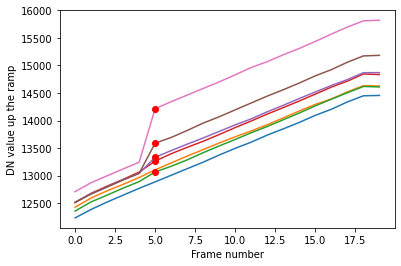

In [10]:
# plot data to see what is being flagged
i=10
nframes = im.meta.exposure.ngroups
frames = np.arange(nframes)

# set up titles for plot
plt.xlabel('Frame number')
plt.ylabel('DN value up the ramp')

for x, y in zip(xpos, ypos):
    # get locations of flagged pixels within the ramps
    jumps = jumpim.groupdq[integration, :, y, x] & dqflags.pixel['JUMP_DET'] > 0
    #print(jumps)
    ramp = jumpim.data[integration, :, y, x]

    #if jumps.any():
        #print('Value of pixel with jump', ramp[jumps])
        #print('Frame of pixel with jump', frames[jumps])

    # plot ramps of selected pixels and flagged jumps
    plt.plot(ramp+i*10)
    plt.plot(frames[jumps], ramp[jumps]+i*10, color='r', marker='o')
    i = i+10

#plt.legend()
plt.show()


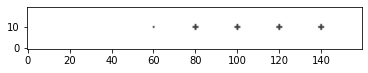

In [11]:
# show region of dq array to see if cross pixels were flagged 
data = jumpim.groupdq[integration, frame, 140:160, 440:600]
plt.imshow(data, cmap='Greys', origin='lower', vmin=0,vmax=5)
plt.show()

<a id="about_ID"></a>
## About this Notebook
**Author:** M. Cracraft, Senior Staff Scientist, INS/MIRI
<br>**Updated On:** 05/29/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 